# Low-pass filter

## Importing data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import load_data
from datetime import datetime
import pandas as pd

data = load_data.load_csv("data/sensordata/linkoping2_NO.csv")
data = data["NO"]
freq = '15min'
data = data.resample(freq).mean()
data = data.interpolate()

## Fourier transform and filtering

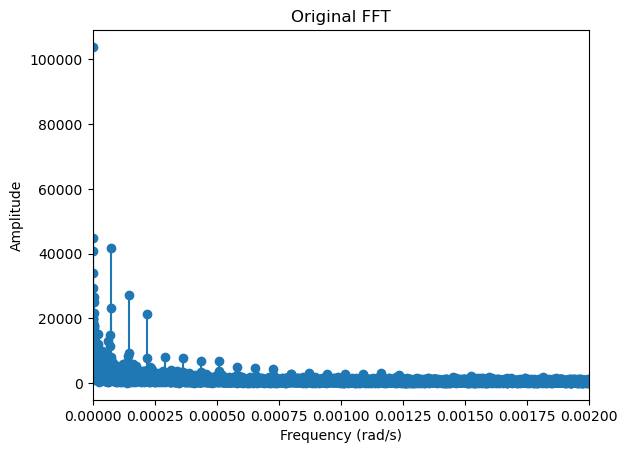

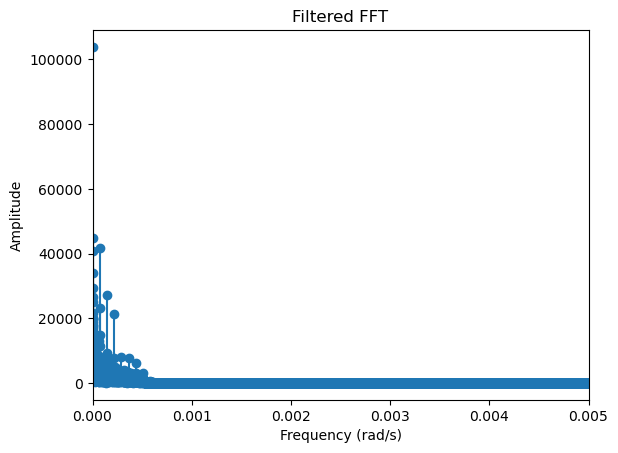

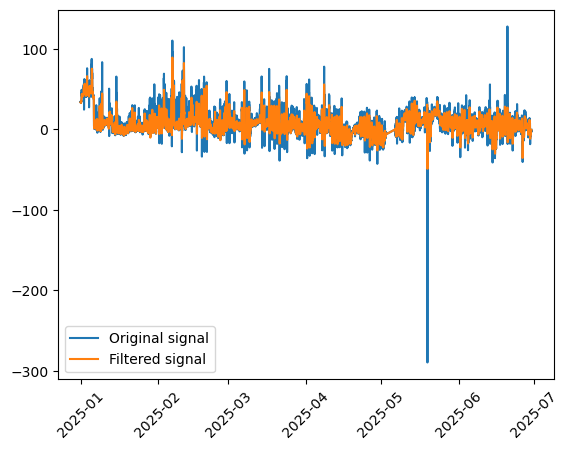

In [24]:
import scipy

dates = data.index

array = data.to_numpy().flatten()
fs = 1/(15*60)
N = len(array)
n = np.arange(N)

Y = np.fft.fft(array)

plt.figure(0)
plt.stem(2*np.pi*fs*n/N,np.abs(Y),basefmt="")
plt.xlim(0,0.002)
plt.title("Original FFT")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (rad/s)")

cutoff = 0.0005
Wn = cutoff/(2*np.pi)/(fs/2)

b, a = scipy.signal.butter(7,Wn,btype='low')

yf = scipy.signal.filtfilt(b, a, array)

YF = np.fft.fft(yf)

plt.figure(1)
plt.title("Filtered FFT")
plt.stem(2*np.pi*fs*n/N,np.abs(YF),basefmt="")
plt.xlim(0,0.005)
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude")


plt.figure(2)
plt.plot(dates, array, label="Original signal")
plt.plot(dates, yf, label="Filtered signal")
plt.xticks(rotation=45)
plt.legend()

# Trying out Welch's method

(0.0, 0.001)

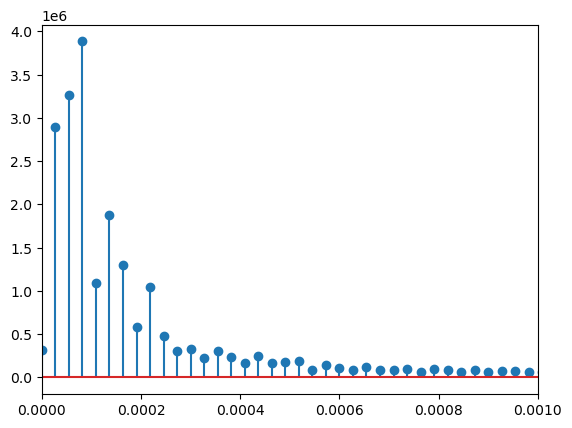

In [3]:
from scipy.signal import welch

f, psd = welch(array, fs, window='hamming', nperseg=256, noverlap=128)
plt.stem(f*2*np.pi,psd)
plt.xlim(0,0.001)

# Noise is a bit clearer to see at around 0.0003 rad/s

## Calculating SNR

In [4]:
noise = array - yf
snr = 10*np.log10(np.sum(yf**2)/np.sum(noise**2))

## Trying out new function

Text(0, 0.5, 'NO Concentration [$\\mu$g/m$^3$]')

<Figure size 640x480 with 0 Axes>

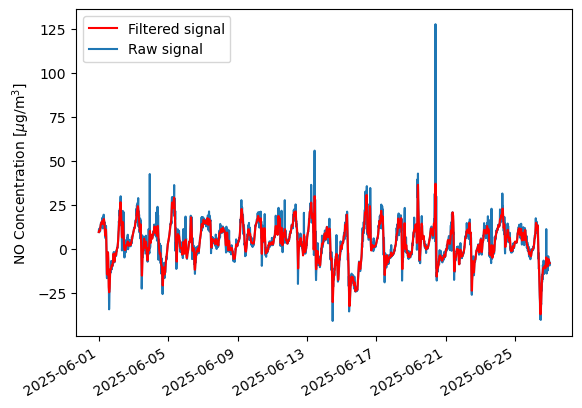

In [25]:
from utils_new import lp_filter
import API_tools as api
import load_data as ld
import unit_conversion as uc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import functions.data_processing as dp
import utils_new as u
import pandas as pd
from functions.data_processing import resample_and_match


sensor = api.load_csv("data/sensordata/linkoping2_NO.csv")
ref, ref_units = ld.load_slb_data("data/refdata/linkoping_ref.json")

for gas in ["NO","NO2","O3","CO"]:
    ref, ref_units = uc.df_ugm3_to_ppb(ref,ref_units,"NO")

start = dt(2025,6,1)
end = dt(2025,6,27)

sensor, ref = resample_and_match(sensor["NO"][start:end].to_frame(), ref["NO"][start:end].to_frame(), '15min')

df = lp_filter(sensor, 15, 0.0009)

plt.figure(1)
ax=df.plot(color='red',zorder=2)
sensor.plot(zorder=1,ax=ax)
plt.legend(["Filtered signal","Raw signal"])
plt.ylabel(r'NO Concentration [$\mu$g/m$^3$]')


## Trying out Hampel filtering

Text(0, 0.5, 'NO Concentration [$\\mu$g/m$^3$]')

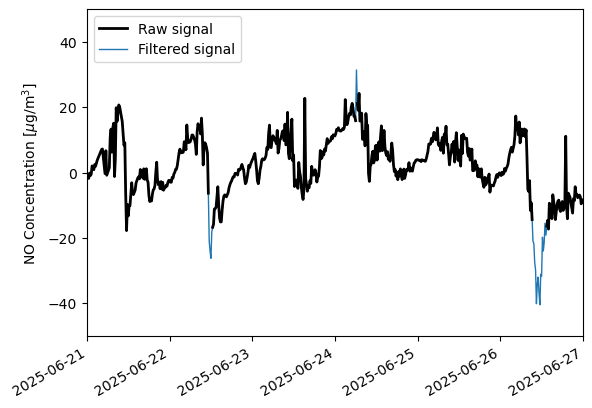

In [26]:
hamp_data = u.hampel_filter(sensor)

ax=hamp_data.plot(color='black', linewidth=2, zorder=2)
sensor.plot(linewidth=1, zorder=1, ax=ax)
start2 = datetime(2025,6,21)
plt.legend(["Raw signal","Filtered signal"],loc='upper left')
plt.xlim(start2,end)
plt.ylim(-50, 50)
plt.ylabel(r'NO Concentration [$\mu$g/m$^3$]')